In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Sep  2 15:59:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

## Movie lens data set


In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V

Downloading...
From: https://drive.google.com/uc?id=1ccoCOvxD2hFm1ejOVRDlT2SivkoNtC6V
To: /content/ml-100k.zip
100% 4.92M/4.92M [00:00<00:00, 19.7MB/s]


In [ ]:
!unzip "ml-100k.zip"  -d  "/content"

Archive:  ml-100k.zip
   creating: /content/ml-100k/
  inflating: /content/ml-100k/allbut.pl  
  inflating: /content/ml-100k/mku.sh  
  inflating: /content/ml-100k/README  
  inflating: /content/ml-100k/u.data  
  inflating: /content/ml-100k/u.genre  
  inflating: /content/ml-100k/u.info  
  inflating: /content/ml-100k/u.item  
  inflating: /content/ml-100k/u.occupation  
  inflating: /content/ml-100k/u.user  
  inflating: /content/ml-100k/u1.base  
  inflating: /content/ml-100k/u1.test  
  inflating: /content/ml-100k/u2.base  
  inflating: /content/ml-100k/u2.test  
  inflating: /content/ml-100k/u3.base  
  inflating: /content/ml-100k/u3.test  
  inflating: /content/ml-100k/u4.base  
  inflating: /content/ml-100k/u4.test  
  inflating: /content/ml-100k/u5.base  
  inflating: /content/ml-100k/u5.test  
  inflating: /content/ml-100k/ua.base  
  inflating: /content/ml-100k/ua.test  
  inflating: /content/ml-100k/ub.base  
  inflating: /content/ml-100k/ub.test  


In [ ]:
!mv ml-100k/* ./

In [ ]:
dateparse = lambda x: datetime.utcfromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')

rating_df = pd.read_csv('u.data', sep='\t', 
                        names=['userID', 'itemID', 'rating', 'time'], 
                       )

movie_df = pd.read_csv('u.item', sep='|', encoding='latin-1',
                    names=['itemID', 'movie', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action', 
                           'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 
                           'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western'])

user_df = pd.read_csv('u.user', sep='|', encoding='latin-1',
                     names=['userID', 'age', 'gender', 'occupation', 'zip_code'])


In [ ]:
rating_df=pd.merge(rating_df,movie_df,on="itemID",how="left")


In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(str)
rating_df["userID"] = rating_df["userID"].astype(str)

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

### Analysis of column timestamp

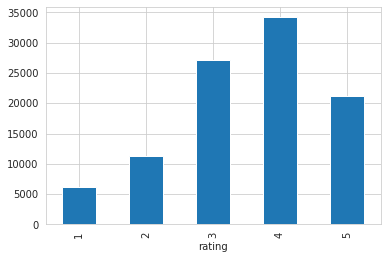

In [ ]:
rating_df.groupby(['rating']).size().plot(kind = "bar")

### Yearwise Analysis

In [ ]:

rating_df['date']=rating_df['time']
rating_df['date']=rating_df.date.apply(lambda x: pd.datetime.fromtimestamp(x).date())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
rating_df['date'] = pd.to_datetime(rating_df.date, format='%Y-%m-%d %H:%M:%S')
rating_df['year'] = rating_df['date'].dt.year

In [ ]:
item_only_df_2015=rating_df[rating_df.year>=2015]

In [ ]:
item_only_df=rating_df

In [ ]:
avg_rating_df = rating_df.groupby('itemID').mean()['rating'].reset_index()
avg_rating_df.rename(columns={'rating':'avg_rating'},inplace=True)
avg_rating_df.sort_values('avg_rating', ascending=[False]).head(10)


,itemID,avg_rating
558,1500,5.0
327,1293,5.0
211,1189,5.0
727,1653,5.0
520,1467,5.0
138,1122,5.0
666,1599,5.0
226,1201,5.0
597,1536,5.0
1477,814,5.0


In [ ]:
total_rating_df = rating_df.groupby('itemID').count()['rating'].reset_index()
total_rating_df.rename(columns={'rating':'num_ratings'},inplace=True)
total_rating_df.sort_values('num_ratings', ascending=[False]).head(10)

,itemID,num_ratings
1128,50,583
859,258,509
2,100,508
774,181,507
899,294,485
890,286,481
892,288,478
0,1,452
907,300,431
235,121,429


In [ ]:
popular_list = total_rating_df.merge(avg_rating_df,on='itemID')
popular_list=popular_list.sort_values(['num_ratings','avg_rating'], ascending=[False,False])
popular_list.head(5)

,itemID,num_ratings,avg_rating
1128,50,583,4.358491
859,258,509,3.803536
2,100,508,4.155512
774,181,507,4.007890
899,294,485,3.156701


In [ ]:
popularitems=popular_list.itemID.values[:10]

In [ ]:
item_only_df =item_only_df.groupby(['itemID','year'],as_index=False)['rating'].agg(['count','mean']).reset_index()



In [ ]:
item_only_df=item_only_df[item_only_df['itemID'].isin(popularitems)]

In [ ]:
item_only_df_2015=item_only_df_2015[item_only_df_2015['itemID'].isin(popularitems)]

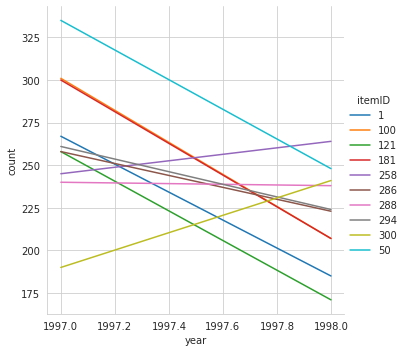

In [ ]:
sns.relplot(x="year", y="count", hue="itemID",
            height=5,
            kind="line", estimator=None, data=item_only_df);

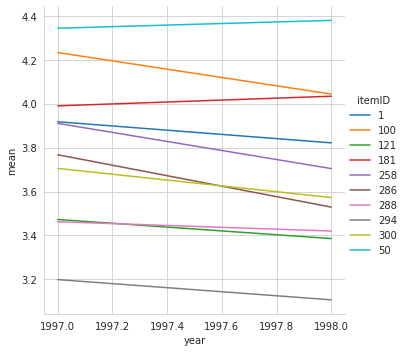

In [ ]:
sns.relplot(x="year", y="mean", hue="itemID",
            height=5,
            kind="line", estimator=None, data=item_only_df);

Trend of movies watch vs year

In [ ]:
popularitems_50=popular_list.itemID.values[:1000]
unpopularitems_50=popular_list.itemID.values[:-1000]

In [ ]:
item_only_50_df=item_only_df[item_only_df['itemID'].isin(popularitems_50)]

In [ ]:
item_only_50_df_count=item_only_50_df.groupby(['year'],as_index=False)['count'].agg(['mean']).reset_index()
item_only_50_df_mean=item_only_50_df.groupby(['year'],as_index=False)['mean'].agg(['mean']).reset_index()

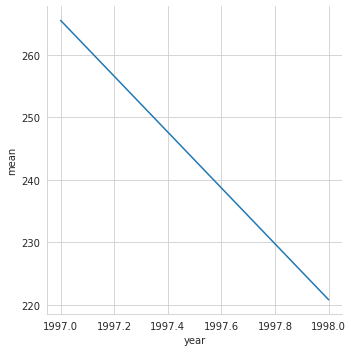

In [ ]:
sns.relplot(x="year", y="mean", 
            height=5,
            kind="line", estimator=None, data=item_only_50_df_count);

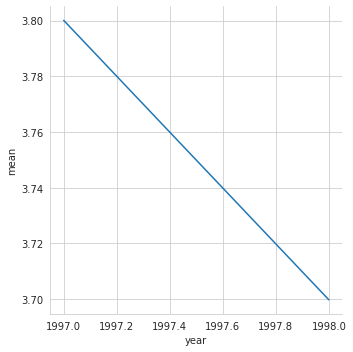

In [ ]:
sns.relplot(x="year", y="mean", 
            height=5,
            kind="line", estimator=None, data=item_only_50_df_mean);

Observations :
It is clear that we there are some clear pattern observed based on year information.So timestamp can be one key features

### SAR Algorithm

In [ ]:
!pip install recommenders

In [ ]:

from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.sar import SAR


In [ ]:
data = rating_df[['userID','itemID','rating','time']]
# Convert the float precision to 32-bit in order to reduce memory consumption 


In [ ]:
data.loc[:, 'rating'] = data['rating'].astype(np.float32)

data.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,userID,itemID,rating,time
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
data.shape

(100000, 4)

In [ ]:
header = {
    "col_user": "userID",
    "col_item": "itemID",
    "col_rating": "rating",
    "col_timestamp": "time",
    "col_prediction": "Prediction",
}
train, test = python_stratified_split(data, ratio=0.8, col_user=header["col_user"], col_item=header["col_item"], seed=42)


In [ ]:
model = SAR(
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

In [ ]:
model.fit(train)

In [ ]:
top_k = model.recommend_k_items(test, top_k=20, remove_seen=True)


In [ ]:
top_k_with_titles = (top_k.join(data[['itemID']].drop_duplicates().set_index('itemID'), 
                                on='itemID', 
                                how='inner').sort_values(by=['userID', 'Prediction'], ascending=False))
display(top_k_with_titles.head(20))

,userID,itemID,Prediction
18840,99,568,10.596852
18841,99,79,10.482389
18842,99,195,10.370702
18843,99,202,10.366434
18844,99,96,10.195569
18845,99,546,10.156565
18846,99,7,10.068504
18847,99,12,10.055834
18848,99,82,10.044115
18849,99,222,9.968143


In [ ]:
# all ranking metrics have the same arguments
TOP_K=20
args = [test, top_k]
kwargs = dict(col_user='userID', 
              col_item='itemID', 
              col_rating='rating', 
              col_prediction='Prediction', 
              relevancy_method='top_k', 
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

In [ ]:
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 20
MAP:		 0.137433
NDCG:		 0.339398
Precision@K:	 0.224867
Recall@K:	 0.276670


## Graphical visualisations

In [ ]:
rating_df.columns

Index(['userID', 'itemID', 'rating', 'time', 'movie', 'release_date',
       'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure',
       'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war', 'western', 'date', 'year'],
      dtype='object')

In [ ]:
rating_df.describe()

,rating,time,video_release_date,unknown,action,adventure,animation,childrens,comedy,crime,...,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western,year
count,100000.000000,1.000000e+05,0.0,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000
mean,3.529860,8.835289e+08,NaN,0.0001,0.255890,0.137530,0.036050,0.071820,0.298320,0.080550,...,0.017330,0.053170,0.049540,0.052450,0.194610,0.12730,0.21872,0.093980,0.018540,1997.471010
std,1.125674,5.343856e+06,NaN,0.0100,0.436362,0.344408,0.186416,0.258191,0.457523,0.272144,...,0.130498,0.224373,0.216994,0.222934,0.395902,0.33331,0.41338,0.291802,0.134894,0.499161
min,1.000000,8.747247e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1997.000000
25%,3.000000,8.794487e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1997.000000
50%,4.000000,8.828269e+08,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1997.000000
75%,4.000000,8.882600e+08,NaN,0.0000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,1998.000000
max,5.000000,8.932866e+08,NaN,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1998.000000


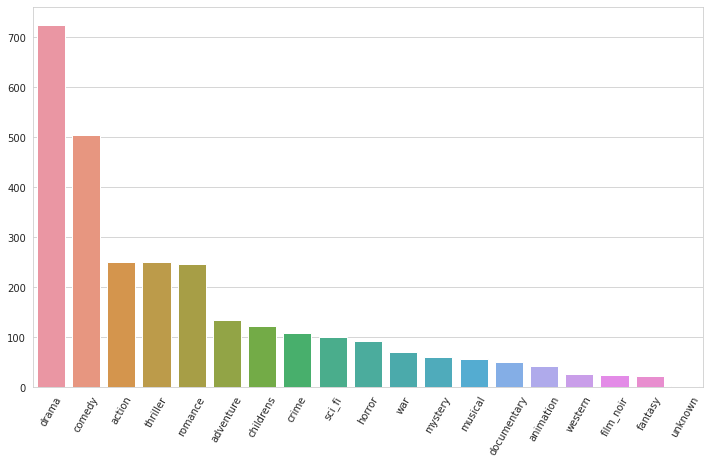

In [ ]:
generes = ['unknown', 'action',
       'adventure', 'animation', 'childrens', 'comedy', 'crime', 'documentary',
       'drama', 'fantasy', 'film_noir', 'horror', 'musical', 'mystery',
       'romance', 'sci_fi', 'thriller', 'war', 'western']

plt.figure(figsize=(12,7))
genere_counts = movie_df.loc[:,generes].sum().sort_values(ascending=False)
sns.barplot(x=genere_counts.index, y=genere_counts.values)
plt.xticks(rotation=60);

In [ ]:
user_df['age_group'] = user_df.age.apply(lambda age: 'Gradeschooler' if 5<=age<=12 else ('Teenager' if 13<=age<=19 else ('Young' if 20<=age<=35 else ('Midlife' if 35<=age<=55 else 'Old'))))

In [ ]:
user_df.sample(5)

,userID,age,gender,occupation,zip_code,age_group
345,346,34,M,other,76059,Young
876,877,30,M,other,77504,Young
558,559,69,M,executive,10022,Old
667,668,29,F,writer,10016,Young
236,237,49,M,administrator,63146,Midlife


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


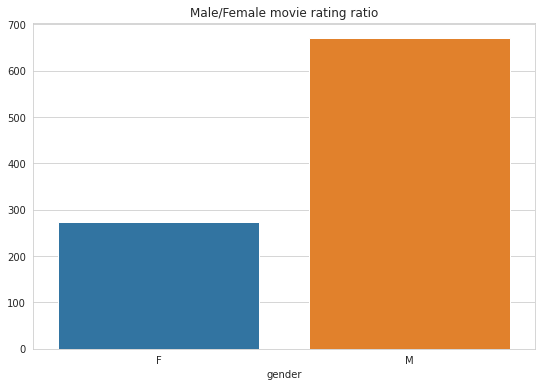

In [ ]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('gender').size().index, user_df.groupby('gender').size().values)
plt.title('Male/Female movie rating ratio');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


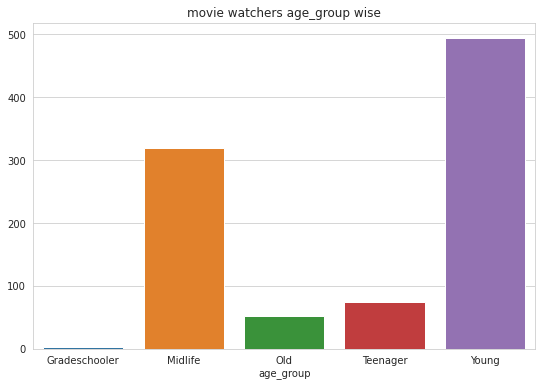

In [ ]:
plt.figure(figsize=(9,6))
sns.barplot(user_df.groupby('age_group').size().index, user_df.groupby('age_group').size().values)
plt.title('movie watchers age_group wise');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


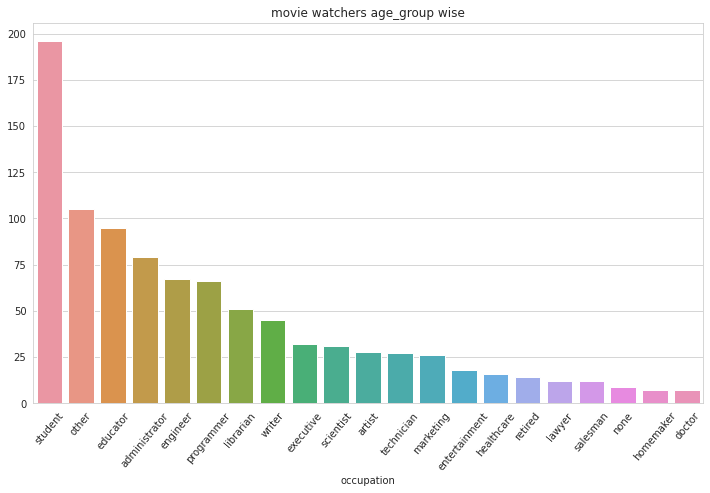

In [ ]:
plt.figure(figsize=(12,7))
movie_watcher_occupants = user_df.groupby('occupation').size().sort_values(ascending=False)
sns.barplot(movie_watcher_occupants.index, movie_watcher_occupants.values)
plt.title('movie watchers age_group wise')
plt.xticks(rotation=50);

In [ ]:

rating_df["itemID"] = rating_df["itemID"].astype(int)
rating_df["userID"] = rating_df["userID"].astype(int)

In [ ]:
rating_user_df = rating_df.join(other=user_df, how='inner', on='userID', lsuffix='_R')
rating_user_movie_df = rating_user_df.join(other=movie_df, how='inner', on='itemID', rsuffix='_M')
rating_movie_df = rating_df.join(other=movie_df, how='inner', on='itemID', rsuffix='_M')

In [ ]:
temp_df = rating_user_movie_df.groupby('gender').sum().loc[:,generes]
temp_df = temp_df.transpose()


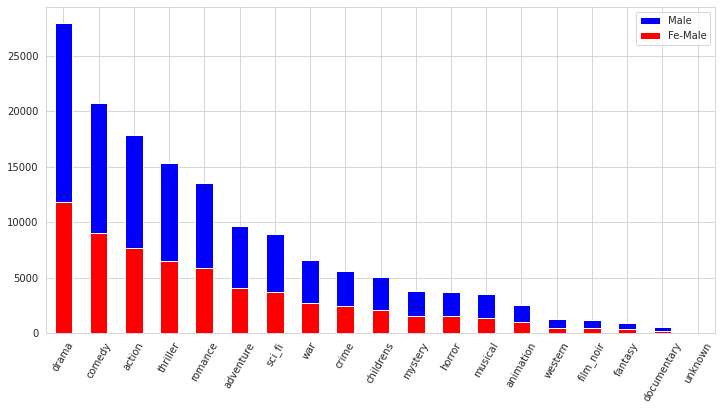

In [ ]:
plt.figure(figsize=(12, 6))

temp_df.M.sort_values(ascending=False).plot(kind='bar', color='blue', label="Male")
temp_df.F.sort_values(ascending=False).plot(kind='bar', color='red', label="Fe-Male")
plt.legend()
plt.xticks(rotation=60)
plt.show()

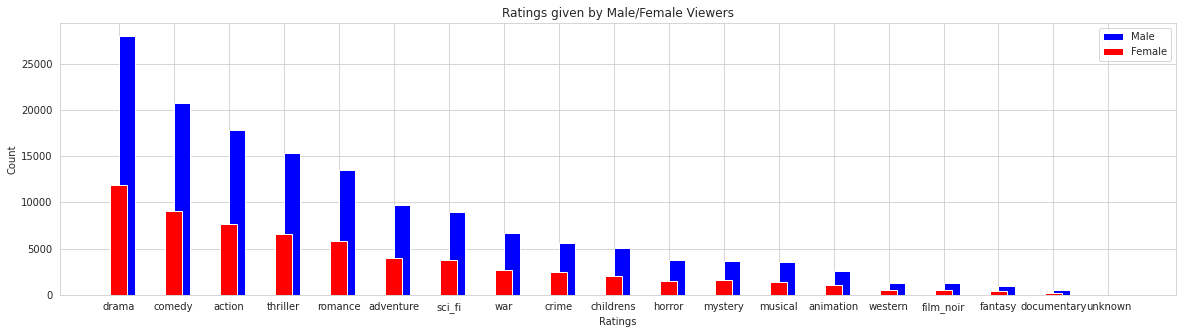

In [ ]:
plt.figure(figsize=(20, 5))
m_temp_df = temp_df.M.sort_values(ascending=False)
f_temp_df = temp_df.F.sort_values(ascending=False)

plt.bar(x=m_temp_df.index, height=m_temp_df.values, label="Male", align="edge", width=0.3, color='blue')
plt.bar(x=f_temp_df.index, height=f_temp_df.values, label="Female", width=0.3, color='red')
plt.title('Ratings given by Male/Female Viewers')
plt.legend()
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [ ]:
top_ten_rated_movies = rating_movie_df.groupby('itemID').size().sort_values(ascending=False)[:10]
top_ten_movie_titles = movie_df.iloc[top_ten_rated_movies.index].movie
top_ten_movie_titles

50      Legends of the Fall (1994)
258    George of the Jungle (1997)
100             Heavy Metal (1981)
181              GoodFellas (1990)
294               Breakdown (1997)
286           Marvin's Room (1996)
288                   Evita (1996)
1                 GoldenEye (1995)
300                In & Out (1997)
121          Cable Guy, The (1996)
Name: movie, dtype: object

## Analyse each of the features on actual rating

#### Gender

In [ ]:
rating_user_movie_df_onlymale=rating_user_movie_df[rating_user_movie_df.gender=='M']
rating_user_movie_df_onlyfemale=rating_user_movie_df[rating_user_movie_df.gender=='F']

In [ ]:
malewatcheditemids=list(rating_user_movie_df_onlymale.itemID)

Movies wathced by only females 

In [ ]:
movieswatchedbyonlyfemales=rating_user_movie_df_onlyfemale [~rating_user_movie_df_onlyfemale.itemID.isin(malewatcheditemids)]

In [ ]:
totalmovieswatchedbyonlyfemales=len(movieswatchedbyonlyfemales.itemID.unique())

In [ ]:
totalmovies=len(rating_df.itemID.unique())

In [ ]:
totalmovieswatchedbyonlyfemales/totalmovies

0.01605231866825208

Observation :
Only 0.016%  movies are unique to females(not watched by any male).So considering this observation gender may not be very effective features to consider

### Agegroup

In [ ]:
list(rating_user_movie_df.age_group.unique())


['Midlife', 'Old', 'Young', 'Teenager', 'Gradeschooler']

In [ ]:
rating_user_movie_df_only_Young=rating_user_movie_df[rating_user_movie_df.age_group=='Young']
rating_user_movie_df_only_old=rating_user_movie_df[rating_user_movie_df.age_group=='Old']
rating_user_movie_df_only_Teenager=rating_user_movie_df[rating_user_movie_df.age_group=='Teenager']

In [ ]:
rating_user_movie_df_only_Young_list=list(rating_user_movie_df_only_Young.itemID.unique())
rating_user_movie_df_only_old_list=list(rating_user_movie_df_only_old.itemID.unique())
rating_user_movie_df_only_Teenager_list=list(rating_user_movie_df_only_Teenager.itemID.unique())

In [ ]:
len(list(set(list(set(rating_user_movie_df_only_Young_list) - set(rating_user_movie_df_only_old_list)))-
set(list(set(rating_user_movie_df_only_Young_list) - set(rating_user_movie_df_only_Teenager_list)))))

215

There are lot of movies which a specific age group watch.So Age group is one improtant features to consider

# Algorithm:




Hybrid recommendation

In [ ]:
!pip install lightfm
!pip install recommenders

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 2.8.2
GPUs:
 [{'device_name': 'Tesla T4', 'total_memory': 15109.75, 'free_memory': 15007.75}]


In [ ]:
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k 
from lightfm.evaluation import recall_at_k 

In [ ]:
# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

In [ ]:
lightFM_df=rating_user_movie_df

In [ ]:
lightFM_df.columns

Index(['userID_R', 'itemID', 'rating', 'time', 'movie', 'release_date',
       'video_release_date', 'imdb_url', 'unknown', 'action', 'adventure',
       'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war', 'western', 'date', 'year', 'userID', 'age',
       'gender', 'occupation', 'zip_code', 'age_group', 'itemID_M', 'movie_M',
       'release_date_M', 'video_release_date_M', 'imdb_url_M', 'unknown_M',
       'action_M', 'adventure_M', 'animation_M', 'childrens_M', 'comedy_M',
       'crime_M', 'documentary_M', 'drama_M', 'fantasy_M', 'film_noir_M',
       'horror_M', 'musical_M', 'mystery_M', 'romance_M', 'sci_fi_M',
       'thriller_M', 'war_M', 'western_M'],
      dtype='object')

In [ ]:
lightFM_df=lightFM_df[['userID', 'itemID', 'rating', 'unknown', 'action', 'adventure',
       'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war', 'western','age_group',]]

In [ ]:
features =list( lightFM_df[[ 'unknown', 'action', 'adventure',
       'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama',
       'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance',
       'sci_fi', 'thriller', 'war']])
#publishers =list( lightFM_df['publisher'])
features=iter(features)
#publishers=iter(publishers)

In [ ]:
user_features =list( lightFM_df[[ 'age_group']])
#publishers =list( lightFM_df['publisher'])
user_features=iter(user_features)
#publishers=iter(publishers)

In [ ]:
dataset = Dataset()

In [ ]:
dataset.fit(users=lightFM_df['userID'], 
            items=lightFM_df['itemID'],
             item_features=features,user_features=user_features)

# quick check to determine the number of unique users and items in the data
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')

Num users: 942, num_items: 1681.


In [ ]:
item_features = dataset.build_item_features((x, y) for x,y in zip(rating_df.itemID,features))
user_features = dataset.build_item_features((x, y) for x,y in zip(rating_df.userID,user_features))

In [ ]:
#  TOP K 
K = 20
# model learning rate
LR = 0.1
# no of latent factors
NO_COMPONENTS = 50
SEED=42
#epochs
EPOCHS=100
# no of threads to fit model
THREADS = 32
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6


In [ ]:
interactions, weights = dataset.build_interactions(lightFM_df.iloc[:, 0:3].values)

train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=.2,
    random_state=np.random.RandomState(SEED))

In [ ]:
model = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LR, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

In [ ]:
model.fit(interactions=train_interactions,
           item_features=item_features,
           epochs=EPOCHS
           )

EVALUATE

In [ ]:
TEST_PERCENTAGE=0.2
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, 
    interactions.col, 
    interactions.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()
cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 1.1 seconds for prepare and predict test data.


In [ ]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()


In [ ]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 1.1 seconds for prepare and predict test data.


In [ ]:
NO_THREADS=6
with Timer() as test_time:
    all_predictions = prepare_all_predictions(lightFM_df, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 550.4 seconds for prepare and predict all data.


In [ ]:
# Import LightFM's evaluation metrics
from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
from lightfm.evaluation import recall_at_k as lightfm_recall_at_k
with Timer() as test_time:
    eval_precision = precision_at_k(rating_true=test_df, 
                                rating_pred=all_predictions, k=K)
    eval_recall = recall_at_k(test_df, all_predictions, k=K)
time_reco3 = test_time.interval

    
print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
   
    sep='\n')

------ Using Repo's evaluation methods ------
Precision@K:	0.204618
Recall@K:	0.258834
